In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from numpy import sqrt
import time

import capytaine as cpt
from capytaine_generator import CapytaineSlantSolver

import sys
import os
sys.path.append(os.path.relpath('../'))
from multi_condensed import Problem

# removes capytaine warnings from clogging outputs
import logging
logging.getLogger("capytaine").setLevel(logging.ERROR)

import pickle

In [2]:
# Different versions of approximating slant with staircase

# staircase with outline on exterior corners
def make_slant_region1(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (offset + i) * delta_d)
  return a_prime, d_prime

# staircase with outlines through centers, starting horizontal, end vertical
def make_slant_region2(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (0.5 + i) * delta_a)
     d_prime.append(d1 + (i) * delta_d)
  a_prime.append(a2)
  d_prime.append(d2)
  return a_prime, d_prime

# staircase with outlines through centers, starting vertical, end horizontal
def make_slant_region3(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (0.5 + i) * delta_d)
  return a_prime, d_prime


# produces variables for approximating MEEM config
def slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version):
  if version == 1:
     make_slant_region = make_slant_region1
  elif version == 2:
     make_slant_region = make_slant_region2
  elif version == 3:
     make_slant_region = make_slant_region3
  else:
     raise ValueError

  a_prime = []
  d_prime = []
  heaving_prime = []
  NMK_prime = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]: # horizontal region
        a_prime.append(a[i])
        d_prime.append(d_in[i])
        heaving_prime.append(heaving[i])
        NMK_prime.append(NMK[i])
    else: # slanted region
       heaving_prime += ([heaving[i]] * res)
       NMK_prime += ([NMK[i]] * res)
       a_inner = 0 if i == 0 else a[i - 1]
       a_add, d_add = make_slant_region(d_in[i], d_out[i], a_inner, a[i], res)
       a_prime += a_add
       d_prime += d_add
  NMK_prime.append(NMK[-1])
  return d_prime, a_prime, heaving_prime, NMK_prime

# Specifically for our 2-region case
def solve_prob(config, res, version, nmk):
  NMK = [nmk, nmk, nmk]
  a, d_in, d_out, heaving = config["a"], config["d_in"], config["d_out"], config["heaving"]
  d_prime, a_prime, heaving_prime, NMK_prime = slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version)
  prob = Problem(config["h"], d_prime, a_prime, heaving_prime, NMK_prime, config["m0"], config["rho"])
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  return prob, x

In [51]:
with open("data/pseudo-slant-3.pkl", "rb") as f:
  configurations = pickle.load(f)

In [53]:
configurations[0].keys()

dict_keys(['name', 'h', 'a', 'd_in', 'd_out', 'heaving', 'NMK', 'm0', 'rho', 'MEEM box AM', 'MEEM box DP', 'CPT box AM', 'CPT box DP', 'MEEM approx AMs', 'MEEM approx DPs', 'CPT approx AMs', 'CPT approx DPs', 'CPT slant AM', 'CPT slant DP'])

In [4]:
# Conduct a quick convergence study to check a good # of terms/region
# See if it's resolution-dependent

def fraction_off(new, base):
  return abs((new - base)/base)

resolutions = [5, 10, 15, 20, 25]
all_convergences = []

for i in [0, 5, 9, 14, 18]:
  config = configurations[i]
  term_convergence = []
  for res in resolutions:
    prob, x = solve_prob(config, res, 3, 2) # version 3, terms/region = 2
    am, dp = prob.hydro_coeffs(x, "capytaine")
    ams = [am]
    dps = [dp]
    for terms in range(3, 51):
      prob, x = solve_prob(config, res, 3, terms)
      am, dp = prob.hydro_coeffs(x, "capytaine")
      ams.append(am)
      dps.append(dp)
      if fraction_off(ams[-1], ams[-2]) < 0.005 and fraction_off(dps[-1], dps[-2]) < 0.005:
        term_convergence.append(terms)
        break
      elif terms == 50:
        term_convergence.append(50)
  all_convergences.append(term_convergence)

In [5]:
print(configurations[5]["CPT slant AM"])
print(configurations[5]["MEEM approx AMs"][-1])
print(configurations[5]["CPT slant DP"])
print(configurations[5]["MEEM approx DPs"][-1])

126168.07523282901
164644.0212019969
1.1634661269339492
1.6044508215821542


In [6]:
# res = 25
# 151443.49254992633 0.684381843842924 #100
# 144995.01272613535 0.7716946527195514 #150
# 143306.40643072198 0.8187600584546425 #200

# res = 30
# 150105.30332435854 0.7251319748360456 #100
# 143438.38064542963 0.7957079263846585 #150
# 141244.9699772406 0.8530128436135318 #200

# res = 40
# 142347.39483047955 0.8350149126044754 #150
# 138823.2579015579 0.8813699786600745 #200

# res = 50
# 138209.9936253744 0.9020630235519791 # 200
# 136068.2543071937 0.9323700378884833 #250

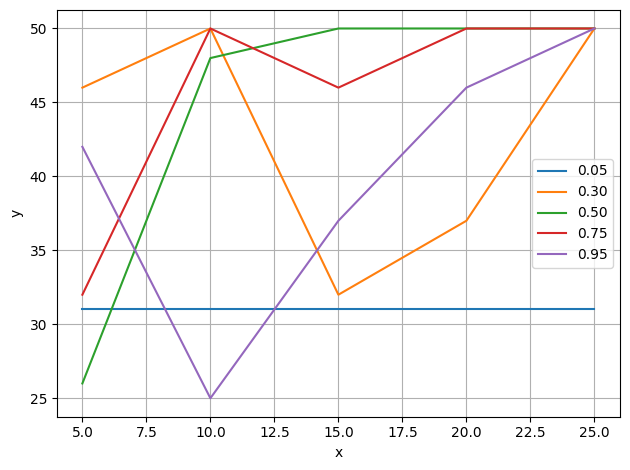

In [ ]:
def plot_multiple_series(x, ys, labs, title = "Graph"):
    for y, label in zip(ys, labs):
        plt.plot(x, y, label=label)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

labs = [f"{(i + 1) * 0.05:.2f}" for i in [0, 5, 9, 14, 18]]
resolutions = [5, 10, 15, 20, 25]
plot_multiple_series(resolutions, all_convergences, labs," < 0.5 percent difference in adjacent terms")

In [11]:
config = configurations[5]
resolutions = list(range(1, 51))
am_array = []
dp_array = []
for res in resolutions:
  prob, x = solve_prob(config, res, 3, 2) # version 3, terms/region = 2
  am, dp = prob.hydro_coeffs(x, "capytaine")
  ams = [am]
  dps = [dp]
  for terms in range(3, 101):
    prob, x = solve_prob(config, res, 3, terms)
    am, dp = prob.hydro_coeffs(x, "capytaine")
    ams.append(am)
    dps.append(dp)
  am_array.append(ams)
  dp_array.append(dps)

In [ ]:
# with open("data/pseudo-slant-4-convergence.pkl", "wb") as f:
#   pickle.dump({"AMs" : am_array,
#                "DPs" : dp_array}, f)

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_83384/730098395.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name)
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_83384/730098395.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


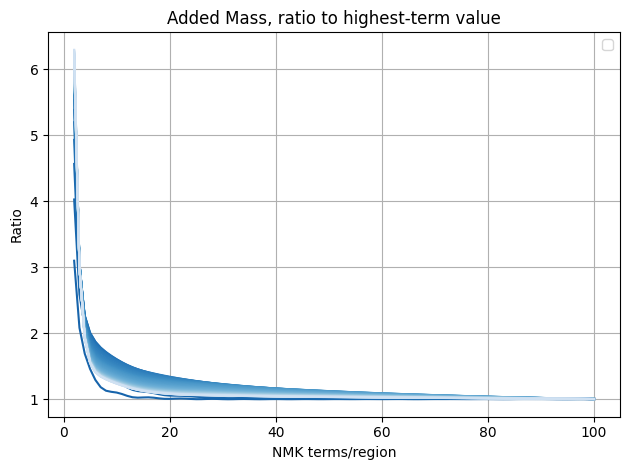

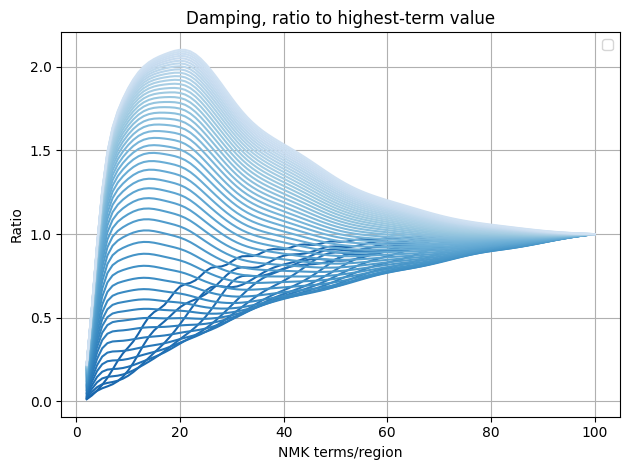

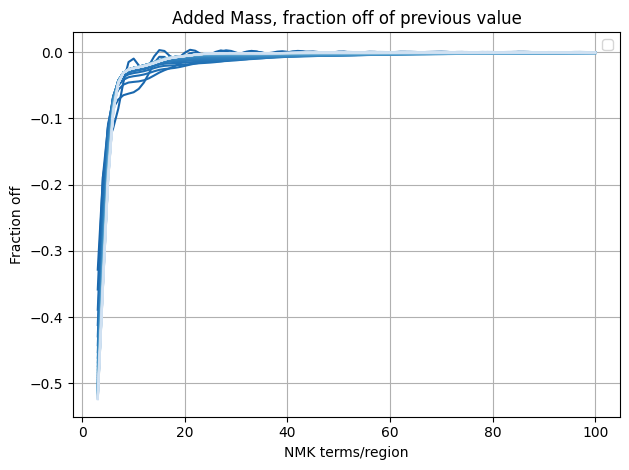

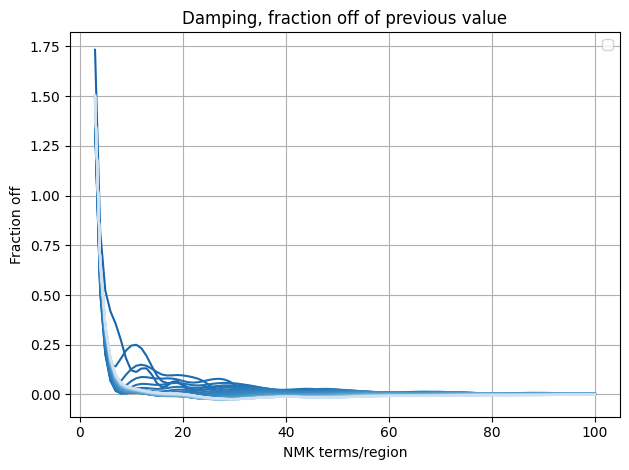

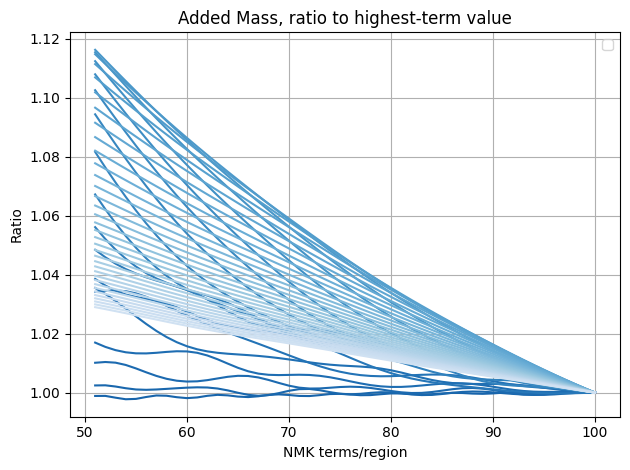

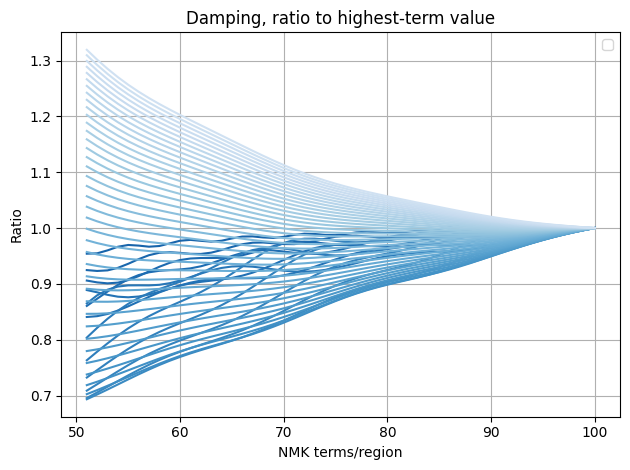

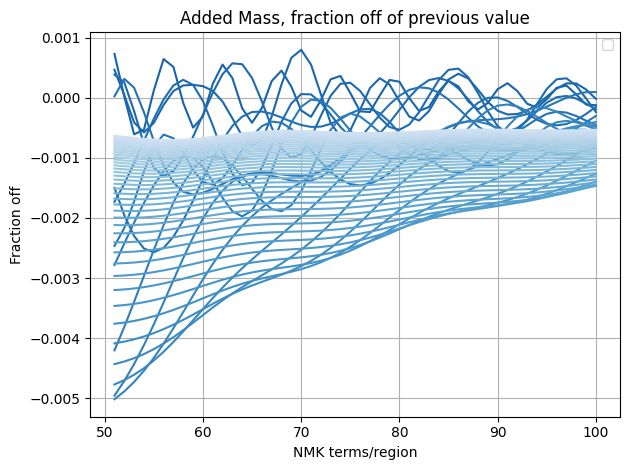

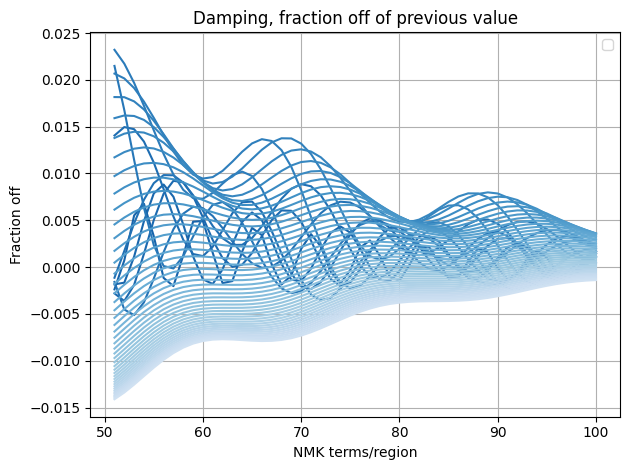

In [ ]:
def plot_multiple_fade(x, ys, labs = None, cmap_name='Blues', last_k = None, title = "plot", xlab = "x", ylab = "y", hline = None, hlab = None):
    n = len(ys)
    cmap = get_cmap(cmap_name)

    color_vals = np.linspace(0.8, 0.2, n)

    if last_k is not None: # get rid of early extreme values for scaling
      x = x[-last_k:]
      ys = [y[-last_k:] for y in ys]

    if labs is None:
      labs = [None] * n

    if hline is not None:
      plt.axhline(y = hline, color='orange', label = hlab)

    for y, label, color_val in zip(ys, labs, color_vals):
        plt.plot(x, y, label = label, color=cmap(color_val))

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


labs = [f"res = {i}" for i in resolutions]

def ratio_conversion(arr):
  return [[value / row[-1] for value in row] for row in arr]

def percent_off(arr):
    return [
        [((row[j] / row[j - 1]) - 1) for j in range(1, len(row))]
        for row in arr
    ]

am_ratio_arr = ratio_conversion(am_array)
dp_ratio_arr = ratio_conversion(dp_array)

am_percent_diff_arr = percent_off(am_array)
dp_percent_diff_arr = percent_off(dp_array)


plot_multiple_fade(list(range(2, 101)), am_ratio_arr, labs = None, title = "Added Mass, ratio to highest-term value",
                   xlab = "NMK terms/region", ylab = "Ratio")
plot_multiple_fade(list(range(2, 101)), dp_ratio_arr, labs = None, title = "Damping, ratio to highest-term value",
                   xlab = "NMK terms/region", ylab = "Ratio")
plot_multiple_fade(list(range(3, 101)), am_percent_diff_arr, labs = None, title = "Added Mass, fraction off of previous value",
                   xlab = "NMK terms/region", ylab = "Fraction off")
plot_multiple_fade(list(range(3, 101)), dp_percent_diff_arr, labs = None, title = "Damping, fraction off of previous value",
                   xlab = "NMK terms/region", ylab = "Fraction off")
plot_multiple_fade(list(range(2, 101)), am_ratio_arr, labs = None, last_k = 50, title = "Added Mass, ratio to highest-term value",
                   xlab = "NMK terms/region", ylab = "Ratio")
plot_multiple_fade(list(range(2, 101)), dp_ratio_arr, labs = None, last_k = 50, title = "Damping, ratio to highest-term value",
                   xlab = "NMK terms/region", ylab = "Ratio")
plot_multiple_fade(list(range(3, 101)), am_percent_diff_arr, labs = None, last_k = 50, title = "Added Mass, fraction off of previous value",
                   xlab = "NMK terms/region", ylab = "Fraction off")
plot_multiple_fade(list(range(3, 101)), dp_percent_diff_arr, labs = None, last_k = 50, title = "Damping, fraction off of previous value",
                   xlab = "NMK terms/region", ylab = "Fraction off")

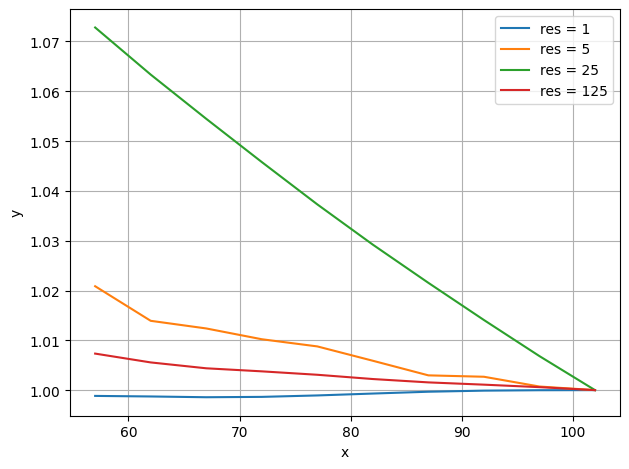

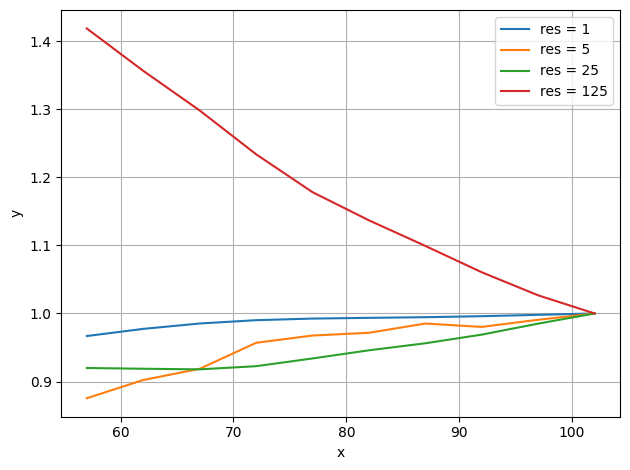

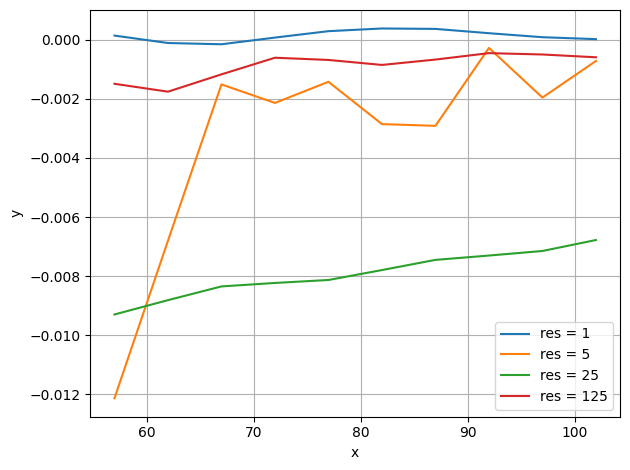

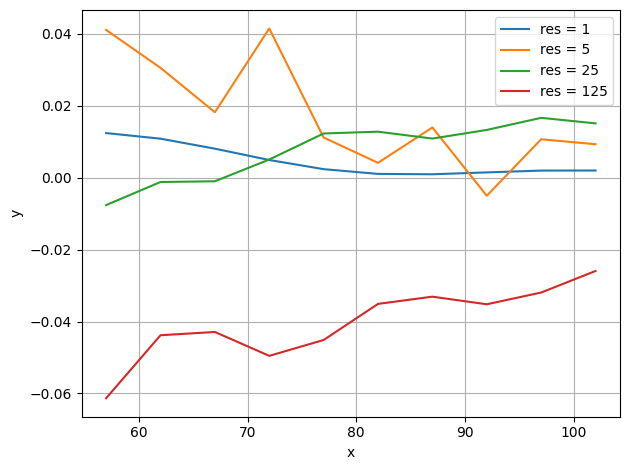

In [ ]:
def last_n_elements(arr, n):
    return [row[-n:] for row in arr]

n = 10

plot_multiple_series(list(range(2, 101)), last_n_elements(am_ratio_arr, n), labs)
plot_multiple_series(list(range(2, 101)), last_n_elements(dp_ratio_arr, n), labs)
plot_multiple_series(list(range(3, 101)), last_n_elements(am_percent_diff_arr, n), labs)
plot_multiple_series(list(range(3, 101)), last_n_elements(dp_percent_diff_arr, n), labs)

In [22]:
def update_data_file(data, name):
  with open(name, "wb") as f:
    pickle.dump(data, f)

In [ ]:
config = configurations[5]
res = 50
am_lst = am_array[-1].copy()
dp_lst = dp_array[-1].copy()

for terms in range(101, 301):
  prob, x = solve_prob(config, res, 3, terms)
  am, dp = prob.hydro_coeffs(x, "capytaine")
  am_lst.append(am)
  dp_lst.append(dp)
  update_data_file({"AMs" : am_lst, "DPs" : dp_lst}, "data/pseudo-slant-4-res-50.pkl")
  print("Finished NMK = " + str(terms))

Finished NMK = 101
Finished NMK = 102
Finished NMK = 103
Finished NMK = 104
Finished NMK = 105
Finished NMK = 106
Finished NMK = 107
Finished NMK = 108
Finished NMK = 109
Finished NMK = 110
Finished NMK = 111
Finished NMK = 112
Finished NMK = 113
Finished NMK = 114
Finished NMK = 115
Finished NMK = 116
Finished NMK = 117
Finished NMK = 118
Finished NMK = 119
Finished NMK = 120
Finished NMK = 121
Finished NMK = 122
Finished NMK = 123
Finished NMK = 124
Finished NMK = 125
Finished NMK = 126
Finished NMK = 127
Finished NMK = 128
Finished NMK = 129
Finished NMK = 130
Finished NMK = 131
Finished NMK = 132
Finished NMK = 133
Finished NMK = 134
Finished NMK = 135
Finished NMK = 136
Finished NMK = 137
Finished NMK = 138
Finished NMK = 139
Finished NMK = 140
Finished NMK = 141
Finished NMK = 142
Finished NMK = 143
Finished NMK = 144
Finished NMK = 145
Finished NMK = 146
Finished NMK = 147
Finished NMK = 148
Finished NMK = 149
Finished NMK = 150
Finished NMK = 151
Finished NMK = 152
Finished NMK

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_83384/730098395.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name)


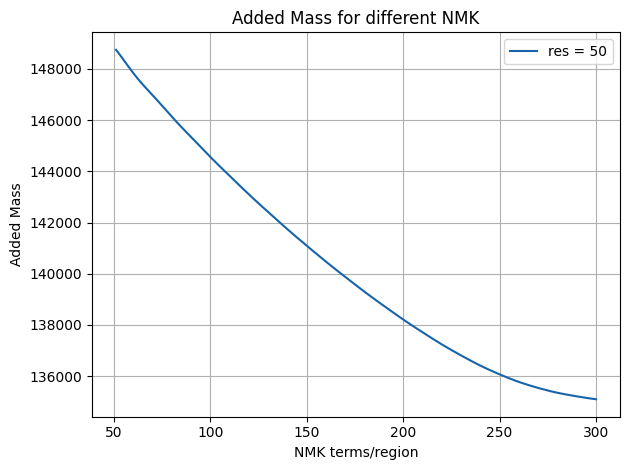

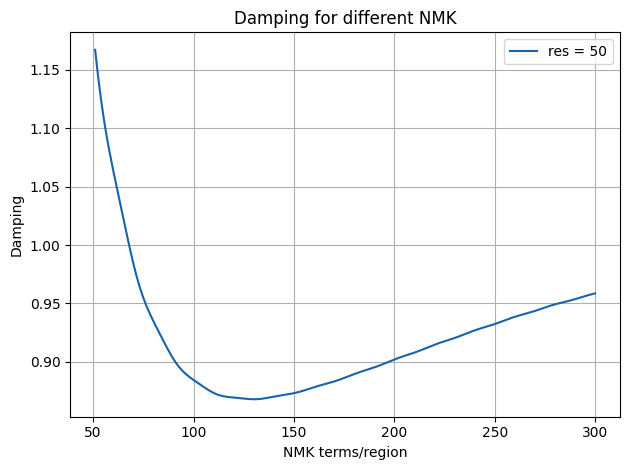

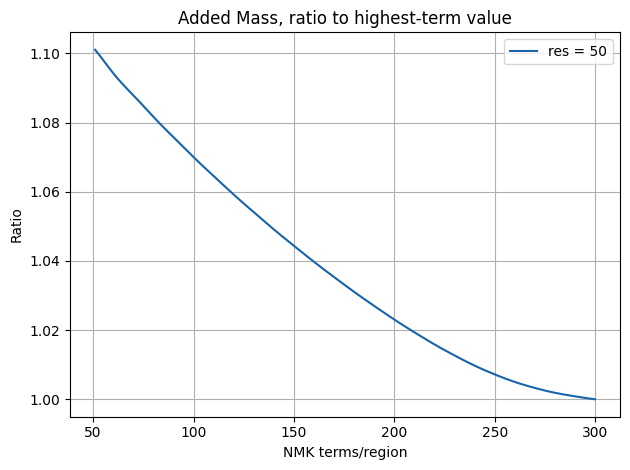

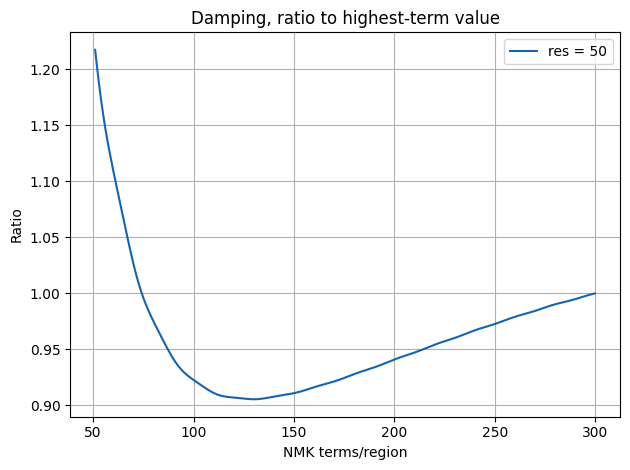

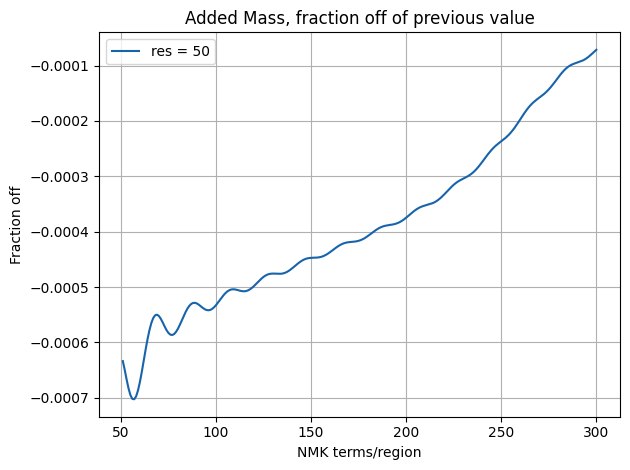

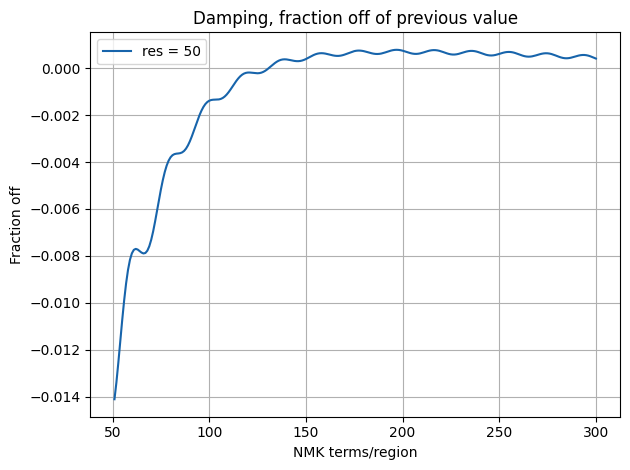

In [50]:
am_ratios = ratio_conversion([am_lst])
dp_ratios = ratio_conversion([dp_lst])

am_percent_diffs = percent_off([am_lst])
dp_percent_diffs = percent_off([dp_lst])

plot_multiple_fade(list(range(2, 301)), [am_lst], labs = ["res = 50"], last_k = 250, title = "Added Mass for different NMK",
                   xlab = "NMK terms/region", ylab = "Added Mass")
plot_multiple_fade(list(range(2, 301)), [dp_lst], labs = ["res = 50"], last_k = 250, title = "Damping for different NMK",
                   xlab = "NMK terms/region", ylab = "Damping")
plot_multiple_fade(list(range(2, 301)), am_ratios, labs = ["res = 50"], last_k = 250, title = "Added Mass, ratio to highest-term value",
                   xlab = "NMK terms/region", ylab = "Ratio")
plot_multiple_fade(list(range(2, 301)), dp_ratios, labs = ["res = 50"], last_k = 250, title = "Damping, ratio to highest-term value",
                   xlab = "NMK terms/region", ylab = "Ratio")
plot_multiple_fade(list(range(2, 301)), am_percent_diffs, labs = ["res = 50"], last_k = 250, title = "Added Mass, fraction off of previous value",
                   xlab = "NMK terms/region", ylab = "Fraction off")
plot_multiple_fade(list(range(2, 301)), dp_percent_diffs, labs = ["res = 50"], last_k = 250, title = "Damping, fraction off of previous value",
                   xlab = "NMK terms/region", ylab = "Fraction off")

In [ ]:
true_am = configurations[5]["CPT slant AM"]
true_dp = configurations[5]["CPT slant DP"]